# Maestría en Inteligencia Artificial Aplicada

## ****Proyecto Integrador: Sistema de visión computacional para normalización y validación visual de anaqueles fríos****

### Tecnológico de Monterrey


## Adtividad de las Semanas 5
### **Avance 3. Baseline**


#### **Nombre de estudiantes:**

- **Carlos Eduardo Ramírez Vázquez** Matrícula: A01795468

- **Cesar Bryam Rodriguez Aybar**    Matrícula: A01795980

- **Wilberth Eduardo López Gómez**   Matrícula: A01795997





In [ ]:
import os, json, random, math
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)

data_path = "/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/"

IMG_DIR = Path(data_path + "unfisheye_data")
ANN_PATH = Path(data_path + "annotations/all_annotations.json")

# Validaciones iniciales

In [ ]:
def _pick(d: dict, keys):
    for k in keys:
        if k in d and d[k] is not None:
            return d[k]
    return None

def load_annotations(ann_path: Path, img_dir: Path):
    data = json.loads(ann_path.read_text(encoding="utf-8"))

    # Caso A: lista de items [{...}, {...}]
    if isinstance(data, list):
        items = data
    # Caso B: dict con key "images" o similar
    elif isinstance(data, dict):
        items = _pick(data, ["images", "items", "data"])
        if items is None:
            # si el dict ya es indexado por id -> item
            if all(isinstance(v, dict) for v in data.values()):
                items = list(data.values())
            else:
                raise ValueError("No pude inferir la lista de imágenes dentro del JSON.")
    else:
        raise ValueError("Formato JSON no soportado.")

    records = []
    for it in items:
        img_rel = _pick(it, ["image_path", "path", "file_name", "filename", "img_path"])
        if img_rel is None:
            raise ValueError(f"Item sin ruta de imagen: keys={list(it.keys())[:10]}")

        doors = _pick(it, ["doors", "annotations", "objects", "polygons"])
        if doors is None:
            raise ValueError(f"Item sin lista de puertas/annotations: keys={list(it.keys())[:10]}")

        # Normalizar doors a lista de puertas, donde cada puerta tiene 4 vertices (x,y)
        norm_doors = []
        for d in doors:
            verts = _pick(d, ["vertices", "points", "keypoints", "polygon"])
            if verts is None:
                # A veces viene directo como lista de puntos
                if isinstance(d, list):
                    verts = d
                else:
                    raise ValueError(f"Puerta sin vertices/points: keys={list(d.keys())[:10]}")

            # verts puede venir como [{"x":..,"y":..}, ...] o [[x,y], ...]
            pts = []
            for p in verts:
                if isinstance(p, dict):
                    x = _pick(p, ["x", "X"])
                    y = _pick(p, ["y", "Y"])
                    if x is None or y is None:
                        raise ValueError(f"Punto dict sin x/y: {p}")
                    pts.append([float(x), float(y)])
                else:
                    # lista/tupla
                    pts.append([float(p[0]), float(p[1])])

            if len(pts) != 4:
                raise ValueError(f"Esperaba 4 puntos por puerta; obtuve {len(pts)} en {img_rel}")

            norm_doors.append(np.array(pts, dtype=np.float32))

        records.append({
            "image_path": str((img_dir / img_rel).resolve()) if not os.path.isabs(img_rel) else img_rel,
            "doors": norm_doors,
        })

    return records

records = load_annotations(ANN_PATH, IMG_DIR)
print(f"Imágenes cargadas: {len(records)}")
print("Ejemplo keys:", records[0].keys())
print("Ejemplo #puertas:", len(records[0]["doors"]))

Imágenes cargadas: 26
Ejemplo keys: dict_keys(['image_path', 'doors'])
Ejemplo #puertas: 4


In [ ]:
def read_image_shape(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"No pude leer imagen: {path}")
    h, w = img.shape[:2]
    return w, h

n_doors_list = []
bad = 0
for r in records:
    w, h = read_image_shape(r["image_path"])
    n_doors_list.append(len(r["doors"]))

    for door in r["doors"]:
        xs, ys = door[:,0], door[:,1]
        if xs.min() < 0 or ys.min() < 0 or xs.max() > w or ys.max() > h:
            bad += 1

print("Distribución #puertas:", {k: n_doors_list.count(k) for k in sorted(set(n_doors_list))})
print("Puertas con puntos fuera de rango (posibles desalineaciones):", bad)

Distribución #puertas: {2: 2, 3: 8, 4: 16}
Puertas con puntos fuera de rango (posibles desalineaciones): 0


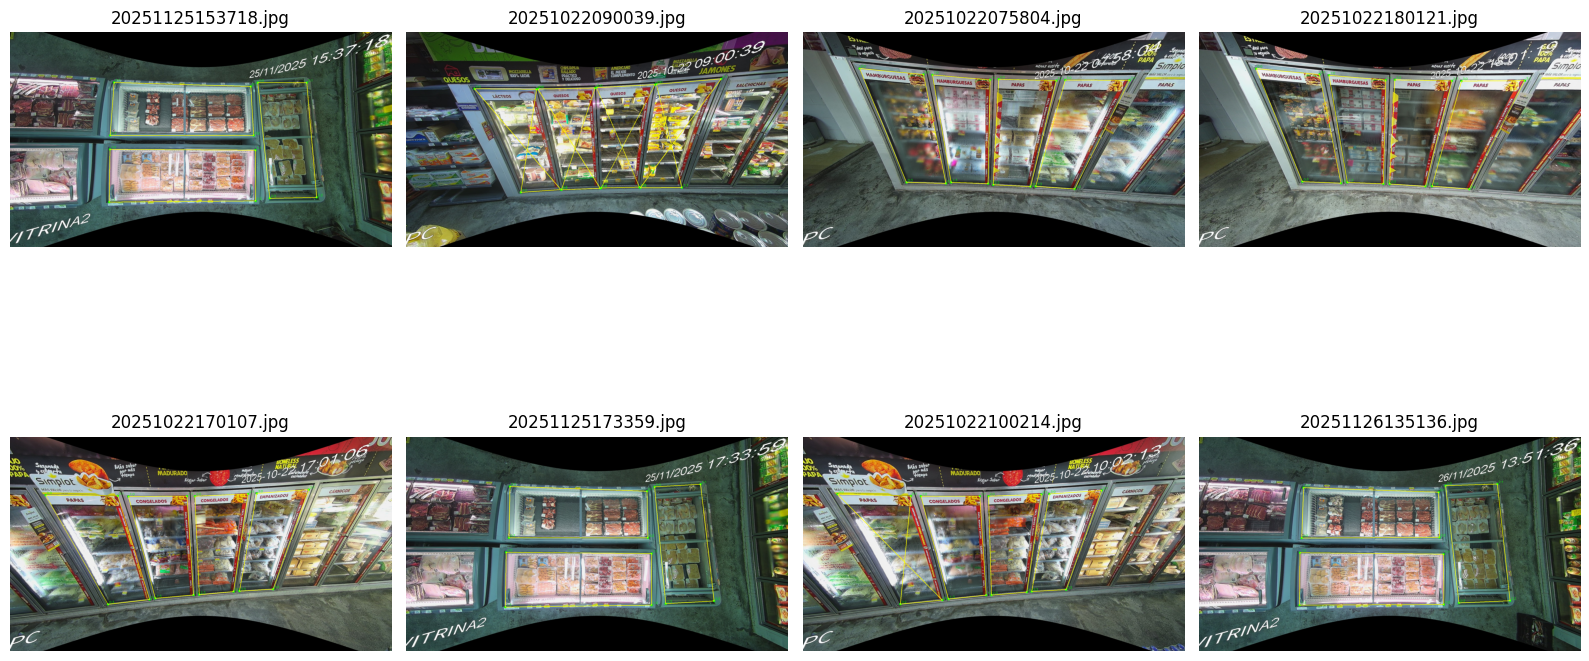

In [ ]:
def draw_doors(img_bgr, doors, radius=6):
    img = img_bgr.copy()
    for di, door in enumerate(doors):
        # puntos
        for pi, (x,y) in enumerate(door):
            cv2.circle(img, (int(x), int(y)), radius, (0,255,0), -1)
            cv2.putText(img, f"{di}:{pi}", (int(x)+6, int(y)-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
        # polígono
        poly = door.reshape(-1,1,2).astype(np.int32)
        cv2.polylines(img, [poly], isClosed=True, color=(0,255,255), thickness=2)
    return img

def show_random(n=6, seed=SEED):
    rng = random.Random(seed)
    sample = rng.sample(records, min(n, len(records)))
    plt.figure(figsize=(16, 10))
    for i, r in enumerate(sample, 1):
        img = cv2.imread(r["image_path"])
        img = draw_doors(img, r["doors"])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, math.ceil(len(sample)/2), i)
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(Path(r["image_path"]).name)
    plt.tight_layout()
    plt.show()

show_random(n=8)

In [ ]:
def order_vertices_tl_tr_br_bl(pts):
    """
    pts: (4,2) float32
    Retorna: (4,2) en orden TL, TR, BR, BL.
    """
    pts = pts.copy()
    # TL = min(x+y), BR = max(x+y); TR = max(x-y), BL = min(x-y)
    s = pts.sum(axis=1)
    d = (pts[:,0] - pts[:,1])
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmax(d)]
    bl = pts[np.argmin(d)]
    return np.stack([tl, tr, br, bl], axis=0).astype(np.float32)

def sort_doors_left_to_right(doors):
    # ordenar por centroide en x
    centroids = [door[:,0].mean() for door in doors]
    idx = np.argsort(centroids)
    return [doors[i] for i in idx]

def canonicalize_record(r):
    doors = [order_vertices_tl_tr_br_bl(d) for d in r["doors"]]
    doors = sort_doors_left_to_right(doors)
    return {"image_path": r["image_path"], "doors": doors}

records_c = [canonicalize_record(r) for r in records]

## Métricas: NME y PCK

In [ ]:
def to_norm(pts, w, h):
    p = pts.copy()
    p[:,0] /= w
    p[:,1] /= h
    return p

def nme(pred_pts, gt_pts, w, h):
    """
    pred_pts, gt_pts: (N,2) en pixeles o en norm; aquí asumimos pixeles y normalizamos por diagonal.
    """
    diag = math.sqrt(w*w + h*h)
    return float(np.mean(np.linalg.norm(pred_pts - gt_pts, axis=1)) / diag)

def pck(pred_pts, gt_pts, thr_px):
    """
    PCK en pixeles: % de puntos con error < thr_px
    """
    err = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return float(np.mean(err < thr_px))

In [ ]:
MAX_DOORS = 4
records_c = [canonicalize_record(r) for r in records]

def build_fixed_target(doors, w, h):
    """
    Retorna:
      y: (MAX_DOORS, 4, 2) en pixeles
      mask: (MAX_DOORS,)
    """
    y = np.zeros((MAX_DOORS, 4, 2), dtype=np.float32)
    mask = np.zeros((MAX_DOORS,), dtype=np.float32)
    n = min(len(doors), MAX_DOORS)
    for i in range(n):
        y[i] = doors[i]
        mask[i] = 1.0
    return y, mask

# Construir dataset en memoria
dataset = []
for r in records_c:
    w, h = read_image_shape(r["image_path"])
    y, mask = build_fixed_target(r["doors"], w, h)
    dataset.append({"image_path": r["image_path"], "w": w, "h": h, "y": y, "mask": mask})

# LOOCV (realista para n=26)
def loocv_mean_shape(ds):
    n = len(ds)
    nme_all, pck_all = [], []
    THR_PX = 10  # ajustable

    for i in range(n):
        train = [ds[j] for j in range(n) if j != i]
        test  = ds[i]

        # mean-shape en coordenadas normalizadas para evitar dependencia de tamaño
        acc = np.zeros((MAX_DOORS, 4, 2), dtype=np.float32)
        cnt = np.zeros((MAX_DOORS, 1, 1), dtype=np.float32)

        for t in train:
            y = t["y"].copy()
            m = t["mask"].copy()
            # normalizar a [0,1]
            y_norm = y.copy()
            y_norm[:,:,0] /= t["w"]
            y_norm[:,:,1] /= t["h"]
            for d in range(MAX_DOORS):
                if m[d] > 0:
                    acc[d] += y_norm[d]
                    cnt[d] += 1

        mean_shape = acc / np.maximum(cnt, 1.0)

        # predecir en pixeles del test
        pred = mean_shape.copy()
        pred[:,:,0] *= test["w"]
        pred[:,:,1] *= test["h"]

        # evaluar solo puertas presentes
        m = test["mask"]
        y = test["y"]

        pred_pts = pred[m>0].reshape(-1,2)
        gt_pts   = y[m>0].reshape(-1,2)

        nme_all.append(nme(pred_pts, gt_pts, test["w"], test["h"]))
        pck_all.append(pck(pred_pts, gt_pts, THR_PX))

    return float(np.mean(nme_all)), float(np.mean(pck_all))

mean_nme, mean_pck = loocv_mean_shape(dataset)
print(f"LOOCV Mean-Shape Prior -> NME: {mean_nme:.4f} | PCK@10px: {mean_pck:.3f}")

LOOCV Mean-Shape Prior -> NME: 0.0737 | PCK@10px: 0.029


## Análisis

El Mean-Shape Prior obtuvo en validación LOOCV un NME = 0.0737 y un PCK@10px = 0.029. En términos prácticos, el NME indica que el error promedio por vértice equivale a ~7.3% de la diagonal de la imagen; para una resolución típica de 1920×1080, esto corresponde a un error del orden de ~160 px por punto. Consistentemente, el PCK@10px (porcentaje de keypoints dentro de 10 px del punto real) es apenas 2.9%, lo que evidencia que casi ningún vértice predicho cae “cerca” del ground truth bajo un umbral estricto.

Este resultado confirma que **no es viable estimar vértices con un prior geométrico** que no use información visual: la variabilidad real entre escenas (posición, escala y encuadre de puertas) no se captura con una forma promedio. En consecuencia, el valor del baseline es principalmente de sanity check (validar el pipeline de parsing, estandarización y métricas) y de establecer un piso cuantitativo: cualquier método con visión debería superar de manera clara estos valores para considerarse un avance real.

# Baseline usando Canny + Hough

**Objetivo**: Detectar automáticamente vértices en la imagen undistorted sin entrenamiento, usando bordes y líneas dominantes. Este baseline sirve para medir si la geometría de puertas es recuperable con técnicas de computer vision tradicionales y tener un comparativo antes de desarrollar modelos alternativos.

In [ ]:
MAX_DOORS = 4
THR_PX = 10  # para PCK@10px

# defaults
CANNY_LOW  = 60
CANNY_HIGH = 160

HOUGH_THRESH = 80
HOUGH_MIN_LINE_LEN = 120
HOUGH_MAX_LINE_GAP = 10

# Clasificación de líneas por ángulo (grados)
VERT_ANGLE_TOL = 12   # cerca de 90°
HORZ_ANGLE_TOL = 12   # cerca de 0°

# Merge de líneas en X/Y
MERGE_DELTA_X = 18
MERGE_DELTA_Y = 18

# Filtros de longitud relativa
MIN_VERT_LEN_FRAC = 0.25  # verticales deben medir al menos 25% de H
MIN_HORZ_LEN_FRAC = 0.35  # horizontales al menos 35% de W

In [ ]:
def preprocess_edges(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, CANNY_LOW, CANNY_HIGH)
    return edges

def hough_lines(edges):
    lines = cv2.HoughLinesP(
        edges, rho=1, theta=np.pi/180,
        threshold=HOUGH_THRESH,
        minLineLength=HOUGH_MIN_LINE_LEN,
        maxLineGap=HOUGH_MAX_LINE_GAP
    )
    if lines is None:
        return []
    return [l[0] for l in lines]  # cada l: (x1,y1,x2,y2)

def line_angle_deg(x1,y1,x2,y2):
    ang = math.degrees(math.atan2((y2-y1), (x2-x1)))
    # normalizar a [0,180)
    ang = ang % 180
    return ang

def split_lines(lines, W, H):
    vlines, hlines = [], []
    min_vlen = MIN_VERT_LEN_FRAC * H
    min_hlen = MIN_HORZ_LEN_FRAC * W

    for x1,y1,x2,y2 in lines:
        ang = line_angle_deg(x1,y1,x2,y2)
        length = math.hypot(x2-x1, y2-y1)

        # vertical ~ 90°
        if abs(ang - 90) <= VERT_ANGLE_TOL and length >= min_vlen:
            vlines.append((x1,y1,x2,y2,length,ang))
        # horizontal ~ 0° (o 180°)
        elif min(abs(ang - 0), abs(ang - 180)) <= HORZ_ANGLE_TOL and length >= min_hlen:
            hlines.append((x1,y1,x2,y2,length,ang))

    return vlines, hlines

In [ ]:
def merge_verticals(vlines):
    """
    Agrupa líneas verticales por posición x (para obtener "fronteras" de puertas).
    Retorna lista de dicts: {"x":..., "ymin":..., "ymax":..., "support":...}
    """
    if not vlines:
        return []

    # representar cada línea por x promedio y su rango y
    reps = []
    for x1,y1,x2,y2,length,ang in vlines:
        x = 0.5*(x1+x2)
        ymin, ymax = (y1,y2) if y1<y2 else (y2,y1)
        reps.append((x, ymin, ymax, length))

    reps.sort(key=lambda t: t[0])
    groups = []
    cur = [reps[0]]
    for r in reps[1:]:
        if abs(r[0] - cur[-1][0]) <= MERGE_DELTA_X:
            cur.append(r)
        else:
            groups.append(cur)
            cur = [r]
    groups.append(cur)

    merged = []
    for g in groups:
        xs = [t[0] for t in g]
        ymins = [t[1] for t in g]
        ymaxs = [t[2] for t in g]
        supp = [t[3] for t in g]
        merged.append({
            "x": float(np.median(xs)),
            "ymin": float(np.percentile(ymins, 10)),
            "ymax": float(np.percentile(ymaxs, 90)),
            "support": float(np.sum(supp))
        })

    # filtrar grupos muy débiles
    merged.sort(key=lambda d: d["x"])
    return merged

def merge_horizontals(hlines):
    """
    Agrupa líneas horizontales por posición y.
    Retorna dicts: {"y":..., "xmin":..., "xmax":..., "support":...}
    """
    if not hlines:
        return []

    reps = []
    for x1,y1,x2,y2,length,ang in hlines:
        y = 0.5*(y1+y2)
        xmin, xmax = (x1,x2) if x1<x2 else (x2,x1)
        reps.append((y, xmin, xmax, length))

    reps.sort(key=lambda t: t[0])
    groups = []
    cur = [reps[0]]
    for r in reps[1:]:
        if abs(r[0] - cur[-1][0]) <= MERGE_DELTA_Y:
            cur.append(r)
        else:
            groups.append(cur)
            cur = [r]
    groups.append(cur)

    merged = []
    for g in groups:
        ys = [t[0] for t in g]
        xmins = [t[1] for t in g]
        xmaxs = [t[2] for t in g]
        supp = [t[3] for t in g]
        merged.append({
            "y": float(np.median(ys)),
            "xmin": float(np.percentile(xmins, 10)),
            "xmax": float(np.percentile(xmaxs, 90)),
            "support": float(np.sum(supp))
        })

    merged.sort(key=lambda d: d["y"])
    return merged

In [ ]:
def choose_top_bottom(merged_v, merged_h, W, H):
    """
    Heurística: si hay horizontales, tomar dos con mayor soporte y separadas (top y bottom).
    Si no, usar percentiles de rangos y de verticales.
    """
    # Caso con horizontales
    if len(merged_h) >= 2:
        # ordenar por soporte desc
        cand = sorted(merged_h, key=lambda d: d["support"], reverse=True)[:6]
        cand = sorted(cand, key=lambda d: d["y"])
        # escoger la más alta y más baja entre las fuertes
        top = cand[0]["y"]
        bottom = cand[-1]["y"]
        # asegurar separación mínima
        if bottom - top >= 0.35 * H:
            return float(top), float(bottom)

    # Fallback: usando verticales
    if merged_v:
        top = float(np.percentile([d["ymin"] for d in merged_v], 15))
        bottom = float(np.percentile([d["ymax"] for d in merged_v], 85))
        # asegurar límites razonables
        top = max(0.0, min(top, H-2.0))
        bottom = max(top+2.0, min(bottom, H-1.0))
        return top, bottom

    # Último fallback
    return 0.1*H, 0.9*H

def build_quads_from_vertical_boundaries(merged_v, top, bottom, W, H, max_doors=MAX_DOORS):
    """
    Usa fronteras verticales (x) ordenadas. Entre pares adyacentes forma rectángulos.
    Devuelve lista de quads en orden TL,TR,BR,BL.
    """
    if len(merged_v) < 2:
        return []

    xs = [d["x"] for d in merged_v]
    xs = sorted(xs)

    # Remover fronteras demasiado cercanas (duplicadas)
    pruned = [xs[0]]
    for x in xs[1:]:
        if abs(x - pruned[-1]) > MERGE_DELTA_X:
            pruned.append(x)
    xs = pruned

    if len(xs) < 2:
        return []

    quads = []
    for i in range(len(xs)-1):
        xl, xr = xs[i], xs[i+1]
        # filtrar puertas demasiado estrechas
        if (xr - xl) < 0.08 * W:
            continue
        quad = np.array([
            [xl, top],     # TL
            [xr, top],     # TR
            [xr, bottom],  # BR
            [xl, bottom],  # BL
        ], dtype=np.float32)
        quads.append(quad)

    # quedarnos con hasta 4, preferir las más anchas (pero mantener orden izq->der)
    if len(quads) > max_doors:
        widths = [(q[1,0]-q[0,0]) for q in quads]
        idx = np.argsort(widths)[::-1][:max_doors]
        idx = sorted(idx)  # volver al orden espacial
        quads = [quads[i] for i in idx]

    return quads

def predict_doors_cv(img_bgr):
    H, W = img_bgr.shape[:2]
    edges = preprocess_edges(img_bgr)
    lines = hough_lines(edges)
    vlines, hlines = split_lines(lines, W, H)
    mv = merge_verticals(vlines)
    mh = merge_horizontals(hlines)
    top, bottom = choose_top_bottom(mv, mh, W, H)
    quads = build_quads_from_vertical_boundaries(mv, top, bottom, W, H, MAX_DOORS)
    debug = {"edges": edges, "lines": lines, "mv": mv, "mh": mh, "top": top, "bottom": bottom}
    return quads, debug

In [ ]:
def nme(pred_pts, gt_pts, w, h):
    diag = math.sqrt(w*w + h*h)
    return float(np.mean(np.linalg.norm(pred_pts - gt_pts, axis=1)) / diag)

def pck(pred_pts, gt_pts, thr_px):
    err = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return float(np.mean(err < thr_px))

def eval_cv_on_dataset(dataset, thr_px=THR_PX, save_debug=False, out_dir=Path("/content/cv_baseline_debug")):
    out_dir.mkdir(parents=True, exist_ok=True)

    nme_list, pck_list = [], []
    cover_list = []  # puertas predichas / puertas GT
    any_fail = 0

    for i, item in enumerate(dataset):
        img = cv2.imread(item["image_path"])
        if img is None:
            any_fail += 1
            continue

        W, H = item["w"], item["h"]
        gt_doors = item["y"]          # (MAX_DOORS,4,2) en px
        gt_mask  = item["mask"]       # (MAX_DOORS,)

        n_gt = int(gt_mask.sum())
        quads_pred, dbg = predict_doors_cv(img)
        n_pred = len(quads_pred)
        m = min(n_gt, n_pred)

        if n_gt == 0:
            continue

        cover_list.append(m / n_gt)

        if m == 0:
            # sin predicción: contar como fail (no podemos calcular NME/PCK matched)
            any_fail += 1
            continue

        pred_pts = np.stack(quads_pred[:m], axis=0).reshape(-1,2)
        gt_pts   = gt_doors[:m].reshape(-1,2)

        nme_list.append(nme(pred_pts, gt_pts, W, H))
        pck_list.append(pck(pred_pts, gt_pts, thr_px))

        if save_debug and (i < 50):
            vis = img.copy()
            # dibujar GT (verde)
            for d in range(n_gt):
                q = gt_doors[d].astype(int).reshape(-1,1,2)
                cv2.polylines(vis, [q], True, (0,255,0), 2)
            # dibujar pred (amarillo)
            for q in quads_pred:
                q2 = q.astype(int).reshape(-1,1,2)
                cv2.polylines(vis, [q2], True, (0,255,255), 2)

            name = Path(item["image_path"]).stem
            cv2.imwrite(str(out_dir / f"{name}_overlay.png"), vis)
            cv2.imwrite(str(out_dir / f"{name}_edges.png"), dbg["edges"])

    summary = {
        "n_samples_eval": len(nme_list),
        "n_fail_no_pred_or_read": any_fail,
        "mean_nme": float(np.mean(nme_list)) if nme_list else None,
        "mean_pck": float(np.mean(pck_list)) if pck_list else None,
        "mean_cover": float(np.mean(cover_list)) if cover_list else None,
    }
    return summary

summary_cv = eval_cv_on_dataset(dataset, thr_px=THR_PX, save_debug=True)
summary_cv

{'n_samples_eval': 4,
 'n_fail_no_pred_or_read': 22,
 'mean_nme': 0.1852794699370861,
 'mean_pck': 0.0,
 'mean_cover': 0.041666666666666664}

El baseline de visión clásica (Canny + Hough + heurísticas geométricas) mostró baja viabilidad operativa en el dominio de anaqueles: en evaluación LOOCV, únicamente 4 de 26 imágenes generaron predicciones evaluables (n_samples_eval=5), mientras que en 22 casos el pipeline no logró proponer puertas utilizables (n_fail_no_pred_or_read=22). Esto se reflejó en una cobertura promedio de apenas 4.17% de las puertas ground truth (mean_cover≈0.041), indicando que el método falla de manera sistemática al recuperar fronteras consistentes (verticales/horizontales) bajo condiciones reales (reflejos, oclusiones por producto, marcos poco visibles y variabilidad de escena).

Incluso en los pocos casos donde se obtuvieron predicciones, el desempeño geométrico fue insuficiente: NME≈0.185 y PCK@10px=0.0, lo que implica errores promedio muy grandes por vértice y ausencia total de aciertos dentro de un umbral estricto de 10 píxeles. En conjunto, estos resultados sustentan que este enfoque basado en reglas no generaliza adecuadamente para el problema y, por tanto, se utiliza principalmente como diagnóstico y como justificación técnica para avanzar hacia un baseline industrial con transfer learning que aprenda invariancias relevantes del dominio.

# Baseline usando YOLO Pose (Ultralytics) + fine-tuning

In [ ]:
!pip -q install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.9 MB/s eta 0:00:00


In [ ]:
import os, json, random, math, shutil
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

YOLO_ROOT = Path(data_path + "yolo_doors_pose")

In [ ]:
def order_vertices_tl_tr_br_bl(pts):
    pts = np.array(pts, dtype=np.float32).copy()
    s = pts.sum(axis=1)
    d = (pts[:,0] - pts[:,1])
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmax(d)]
    bl = pts[np.argmin(d)]
    return np.stack([tl, tr, br, bl], axis=0).astype(np.float32)

def sort_doors_left_to_right(doors):
    centroids_x = [np.mean(np.array(d)[:,0]) for d in doors]
    idx = np.argsort(centroids_x)
    return [doors[i] for i in idx]

def load_records_simple(ann_path: Path, img_dir: Path):
    data = json.loads(ann_path.read_text(encoding="utf-8"))
    # Asumimos lista de items o dict con "images"
    if isinstance(data, dict) and "images" in data:
        items = data["images"]
    elif isinstance(data, list):
        items = data
    elif isinstance(data, dict):
        items = list(data.values())
    else:
        raise ValueError("JSON no soportado.")

    recs = []
    for it in items:
        img_rel = it.get("image_path") or it.get("path") or it.get("file_name") or it.get("filename")
        doors = it.get("doors") or it.get("annotations") or it.get("objects") or it.get("polygons")
        if img_rel is None or doors is None:
            continue

        full_path = Path(img_rel)
        if not full_path.is_absolute():
            full_path = (img_dir / img_rel).resolve()

        norm_doors = []
        for d in doors:
            verts = d.get("vertices") if isinstance(d, dict) else None
            if verts is None:
                verts = d.get("points") if isinstance(d, dict) else None
            if verts is None and isinstance(d, list):
                verts = d
            if verts is None:
                continue

            pts = []
            for p in verts:
                if isinstance(p, dict):
                    pts.append([float(p["x"]), float(p["y"])])
                else:
                    pts.append([float(p[0]), float(p[1])])

            if len(pts) != 4:
                continue

            pts = order_vertices_tl_tr_br_bl(pts)
            norm_doors.append(pts)

        if not norm_doors:
            continue

        norm_doors = sort_doors_left_to_right(norm_doors)  # orden izq->der
        recs.append({"image_path": str(full_path), "doors": norm_doors})

    if not recs:
        raise ValueError("No se cargaron registros. Revisa el esquema del JSON/rutas.")
    return recs

records = load_records_simple(ANN_PATH, IMG_DIR)
print("Imágenes con al menos 1 puerta:", len(records))
print("Ejemplo:", records[0]["image_path"], "#doors:", len(records[0]["doors"]))

Imágenes con al menos 1 puerta: 26
Ejemplo: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/unfisheye_data/20251022075804.jpg #doors: 4


In [ ]:
def strat_key(r):
    # estratificar por #puertas (1..4)
    return min(len(r["doors"]), 4)

# split 80/20 estratificado simple
byk = {}
for r in records:
    byk.setdefault(strat_key(r), []).append(r)

train, val = [], []
for k, lst in byk.items():
    random.shuffle(lst)
    cut = max(1, int(0.8 * len(lst))) if len(lst) > 1 else 1
    train += lst[:cut]
    val   += lst[cut:]

print("Train:", len(train), "Val:", len(val), "Distribución val:", {k: sum(1 for r in val if strat_key(r)==k) for k in sorted(byk)})

Train: 19 Val: 7 Distribución val: {2: 1, 3: 2, 4: 4}


In [ ]:
def make_dirs(root: Path):
    for p in [
        root/"images/train", root/"images/val",
        root/"labels/train", root/"labels/val",
    ]:
        p.mkdir(parents=True, exist_ok=True)

def bbox_from_quad(quad):
    xs, ys = quad[:,0], quad[:,1]
    x1, y1, x2, y2 = float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max())
    return x1, y1, x2, y2

def yolo_norm_bbox(x1,y1,x2,y2,W,H):
    cx = ((x1+x2)/2)/W
    cy = ((y1+y2)/2)/H
    w  = (x2-x1)/W
    h  = (y2-y1)/H
    return cx, cy, w, h

def write_label_pose(txt_path: Path, doors, W, H, max_doors=4):
    # Regla de proyecto: máximo 4 puertas, estrictamente las 4 MÁS A LA IZQUIERDA
    doors = doors[:max_doors]

    lines = []
    for quad in doors:
        x1,y1,x2,y2 = bbox_from_quad(quad)
        cx,cy,w,h = yolo_norm_bbox(x1,y1,x2,y2,W,H)

        # keypoints: 4 puntos (TL,TR,BR,BL) normalizados + v=2 (visible)
        kpts = []
        for (x,y) in quad:
            kpts += [x/W, y/H, 2]  # v=2 visible (formato común)
        # clase 0 = "door"
        row = [0, cx, cy, w, h] + kpts
        lines.append(" ".join(f"{v:.6f}" if isinstance(v, float) else str(v) for v in row))

    txt_path.write_text("\n".join(lines) + ("\n" if lines else ""), encoding="utf-8")

def export_split(split, split_name: str):
    for r in split:
        src = Path(r["image_path"])
        img = cv2.imread(str(src))
        if img is None:
            continue
        H, W = img.shape[:2]

        dst_img = YOLO_ROOT / f"images/{split_name}/{src.name}"
        dst_lbl = YOLO_ROOT / f"labels/{split_name}/{src.stem}.txt"

        shutil.copy2(src, dst_img)
        write_label_pose(dst_lbl, r["doors"], W, H)

make_dirs(YOLO_ROOT)
export_split(train, "train")
export_split(val, "val")

print("Ejemplo label:", (YOLO_ROOT/"labels/train").glob("*.txt").__iter__().__next__())

Ejemplo label: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_doors_pose/labels/train/20251022170107.txt


In [ ]:
from pathlib import Path

data_yaml = Path("/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_doors_pose/data.yaml")
YOLO_ROOT = data_yaml.parent  # .../yolo_doors_pose

data_yaml.write_text(
f'''path: "{YOLO_ROOT}"

train: images/train
val: images/val

nc: 1
names:
  0: door

kpt_shape: [4, 3]
# TL, TR, BR, BL. Si activaras flip horizontal: TL<->TR y BL<->BR
flip_idx: [1, 0, 3, 2]
''',
encoding="utf-8"
)

print(data_yaml.read_text())

path: "/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_doors_pose"

train: images/train
val: images/val

nc: 1
names:
  0: door

kpt_shape: [4, 3]
# TL, TR, BR, BL. Si activaras flip horizontal: TL<->TR y BL<->BR
flip_idx: [1, 0, 3, 2]



In [ ]:
from ultralytics import YOLO

# Intentar varios nombres de pesos preentrenados (cambian según versión)
candidates = ["yolov8n-pose.pt", "yolo11n-pose.pt", "yolo26n-pose.pt"]
model = None
last_err = None
for w in candidates:
    try:
        model = YOLO(w)
        print("Usando pesos:", w)
        break
    except Exception as e:
        last_err = e

if model is None:
    raise RuntimeError(f"No pude cargar pesos pose. Último error: {last_err}")

train_res = model.train(
    data=str(data_yaml),
    epochs=80,
    imgsz=640,
    batch=4,
    lr0=1e-3,
    weight_decay=5e-4,
    patience=20,
    # Augmentación: conservadora
    mosaic=0.0,
    fliplr=0.0,
    flipud=0.0,
    degrees=0.0,
    translate=0.0,
    scale=0.0,
    shear=0.0,
    perspective=0.0,
    # Freeze parcial (ayuda con datasets diminutos)
    freeze=10,
    verbose=True
)

Usando pesos: yolov8n-pose.pt
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_doors_pose/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-pose.pt, momentum=0.937, mosaic=0.0, multi_scale=0.0, name=train2, nbs

In [ ]:
def nme(pred_pts, gt_pts, W, H):
    diag = math.sqrt(W*W + H*H)
    return float(np.mean(np.linalg.norm(pred_pts - gt_pts, axis=1)) / diag)

def pck(pred_pts, gt_pts, thr_px=10):
    err = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return float(np.mean(err < thr_px))

def load_gt_from_label(txt_path: Path, W, H):
    """
    Lee label YOLO Pose y reconstruye quads en px.
    Retorna lista de quads (4,2) en TL,TR,BR,BL.
    """
    if not txt_path.exists():
        return []
    lines = [l.strip() for l in txt_path.read_text().splitlines() if l.strip()]
    quads = []
    for l in lines:
        parts = l.split()
        # cls cx cy w h + 4*(x y v)=12 -> total 17
        if len(parts) < 5 + 12:
            continue
        k = parts[5:]
        pts = []
        for i in range(0, 12, 3):
            x = float(k[i]) * W
            y = float(k[i+1]) * H
            pts.append([x,y])
        quads.append(np.array(pts, dtype=np.float32))
    # ya están en orden canónico porque así los exportamos
    # limitar a 4 (izq->der)
    quads = sort_doors_left_to_right(quads)[:4]
    return quads

def predict_quads_ultralytics(model, img_path: Path, conf=0.25):
    r = model.predict(source=str(img_path), conf=conf, verbose=False)[0]
    if r.keypoints is None:
        return []
    # keypoints.xy: (n, k, 2) en px
    kxy = r.keypoints.xy.cpu().numpy()  # (n,4,2) esperado
    # ordenar por centroide x y quedarse con 4 más a la izquierda
    quads = [kxy[i].astype(np.float32) for i in range(kxy.shape[0])]
    quads = sort_doors_left_to_right(quads)[:4]
    return quads

def eval_yolo_pose(model, yolo_root: Path, thr_px=10):
    val_imgs = sorted((yolo_root/"images/val").glob("*"))
    nme_list, pck_list, cover_list = [], [], []

    for img_path in val_imgs:
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        H, W = img.shape[:2]

        gt = load_gt_from_label(yolo_root/"labels/val"/f"{img_path.stem}.txt", W, H)
        pred = predict_quads_ultralytics(model, img_path, conf=0.25)

        m = min(len(gt), len(pred))
        if len(gt) == 0:
            continue

        cover_list.append(m / len(gt))
        if m == 0:
            continue

        pred_pts = np.stack(pred[:m], axis=0).reshape(-1,2)
        gt_pts   = np.stack(gt[:m], axis=0).reshape(-1,2)

        nme_list.append(nme(pred_pts, gt_pts, W, H))
        pck_list.append(pck(pred_pts, gt_pts, thr_px))

    return {
        "n_val_images": len(val_imgs),
        "mean_nme": float(np.mean(nme_list)) if nme_list else None,
        "mean_pck": float(np.mean(pck_list)) if pck_list else None,
        "mean_cover": float(np.mean(cover_list)) if cover_list else None,
        "n_eval": len(nme_list),
    }

summary_pose = eval_yolo_pose(model, YOLO_ROOT, thr_px=10)
summary_pose

{'n_val_images': 7,
 'mean_nme': 0.03524157564554896,
 'mean_pck': 0.017857142857142856,
 'mean_cover': 1.0,
 'n_eval': 7}

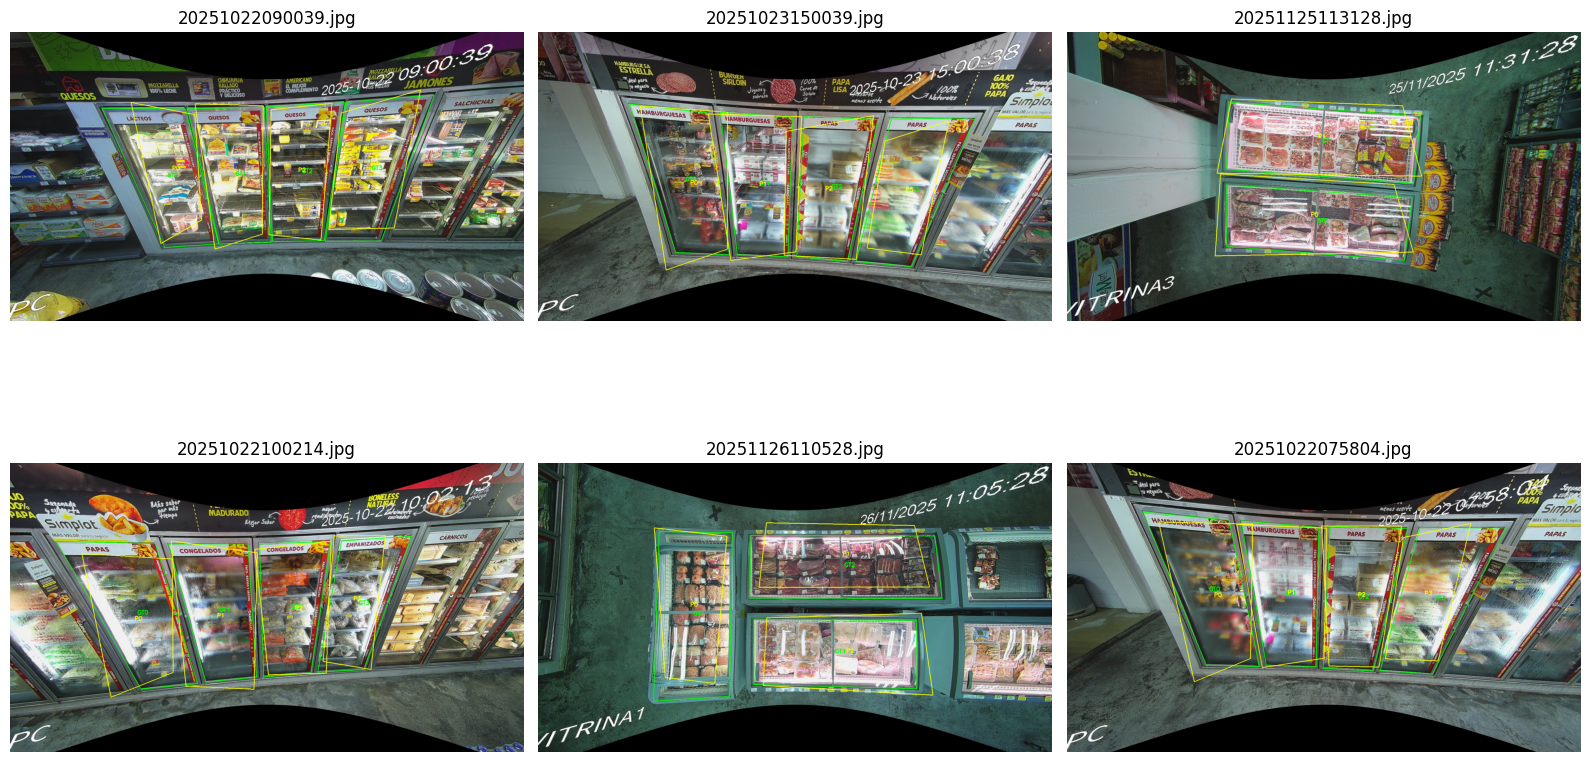

In [ ]:
def draw_quads(img_bgr, quads, color, label):
    out = img_bgr.copy()
    for i, q in enumerate(quads):
        poly = q.reshape(-1,1,2).astype(np.int32)
        cv2.polylines(out, [poly], True, color, 2)
        cx = int(q[:,0].mean()); cy = int(q[:,1].mean())
        cv2.putText(out, f"{label}{i}", (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return out

def show_preds(n=6, seed=42):
    imgs = sorted((YOLO_ROOT/"images/val").glob("*"))
    random.Random(seed).shuffle(imgs)
    imgs = imgs[:min(n, len(imgs))]

    plt.figure(figsize=(16, 10))
    for i, p in enumerate(imgs, 1):
        img = cv2.imread(str(p))
        H, W = img.shape[:2]
        gt = load_gt_from_label(YOLO_ROOT/"labels/val"/f"{p.stem}.txt", W, H)
        pr = predict_quads_ultralytics(model, p, conf=0.25)

        vis = draw_quads(img, gt, (0,255,0), "GT")
        vis = draw_quads(vis, pr, (0,255,255), "P")

        vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
        plt.subplot(2, math.ceil(len(imgs)/2), i)
        plt.imshow(vis); plt.axis("off"); plt.title(p.name)

    plt.tight_layout(); plt.show()

show_preds()

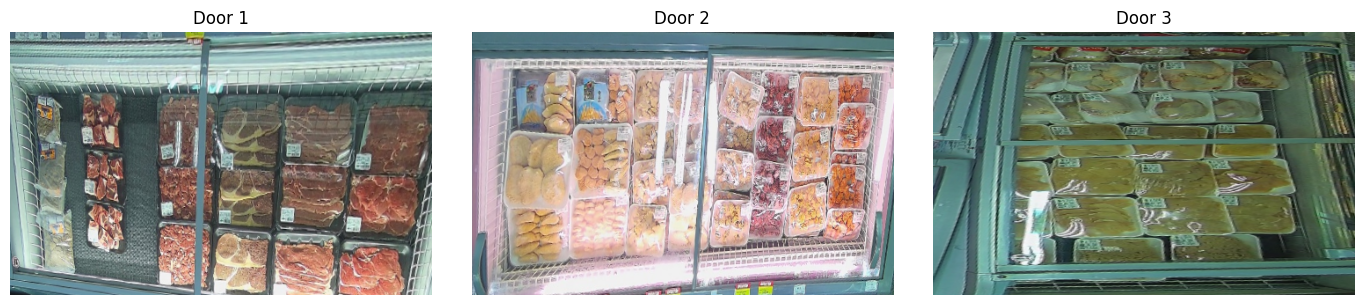

In [ ]:
def warp_door_patch(img_bgr, quad, out_w=480, out_h=300):
    src = quad.astype(np.float32)
    dst = np.array([[0,0],[out_w,0],[out_w,out_h],[0,out_h]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    patch = cv2.warpPerspective(img_bgr, M, (out_w, out_h))
    return patch

def demo_rectification(seed=42):
    imgs = sorted((YOLO_ROOT/"images/val").glob("*"))
    if not imgs:
        print("No hay val.")
        return
    p = random.Random(seed).choice(imgs)

    img = cv2.imread(str(p))
    H, W = img.shape[:2]
    pr = predict_quads_ultralytics(model, p, conf=0.25)

    if not pr:
        print("Sin predicciones en:", p.name)
        return

    patches = [warp_door_patch(img, q) for q in pr]
    plt.figure(figsize=(14, 3))
    for i, patch in enumerate(patches, 1):
        plt.subplot(1, len(patches), i)
        plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Door {i}")
    plt.tight_layout(); plt.show()

demo_rectification()

## Análisis

Cobertura (mean_cover = 1.0): en las 7 imágenes de validación, el modelo está produciendo al menos tantas puertas como las etiquetadas, a diferencia del baseline anterior.

NME = 0.0352: error medio ≈ 3.5% de la diagonal. Al ser imágenes de ~1920×1080 (diag ≈ 2203 px), el error medio ronda ~77 px por vértice.

PCK@10px = 0.0179: bajo, pero coherente con ~77 px de error medio. Con tan poca data, es esperable que el error medio sea aun alto.

In [ ]:
def eval_yolo_pose_multi_pck(model, yolo_root, thrs=(10,20,50,100)):
    val_imgs = sorted((Path(yolo_root)/"images/val").glob("*"))
    pcks = {t: [] for t in thrs}
    nmes, covers = [], []

    for img_path in val_imgs:
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        H, W = img.shape[:2]
        gt = load_gt_from_label(Path(yolo_root)/"labels/val"/f"{img_path.stem}.txt", W, H)
        pred = predict_quads_ultralytics(model, img_path, conf=0.25)

        m = min(len(gt), len(pred))
        if len(gt) == 0:
            continue
        covers.append(m/len(gt))
        if m == 0:
            continue

        pred_pts = np.stack(pred[:m], axis=0).reshape(-1,2)
        gt_pts   = np.stack(gt[:m], axis=0).reshape(-1,2)
        nmes.append(nme(pred_pts, gt_pts, W, H))
        for t in thrs:
            pcks[t].append(pck(pred_pts, gt_pts, t))

    return {
        "n_val_images": len(val_imgs),
        "mean_nme": float(np.mean(nmes)) if nmes else None,
        "mean_cover": float(np.mean(covers)) if covers else None,
        **{f"mean_pck@{t}px": float(np.mean(pcks[t])) if pcks[t] else None for t in thrs}
    }

eval_yolo_pose_multi_pck(model, YOLO_ROOT)

{'n_val_images': 7,
 'mean_nme': 0.03524157564554896,
 'mean_cover': 1.0,
 'mean_pck@10px': 0.017857142857142856,
 'mean_pck@20px': 0.08333333333333334,
 'mean_pck@50px': 0.5892857142857143,
 'mean_pck@100px': 0.8601190476190476}

In [ ]:
OUT = Path(data_path + "yolo_pose_outputs")
(OUT/"overlays").mkdir(parents=True, exist_ok=True)
(OUT/"patches").mkdir(parents=True, exist_ok=True)

val_imgs = sorted((YOLO_ROOT/"images/val").glob("*"))
for img_path in val_imgs:
    img = cv2.imread(str(img_path))
    H, W = img.shape[:2]
    gt = load_gt_from_label(YOLO_ROOT/"labels/val"/f"{img_path.stem}.txt", W, H)
    pr = predict_quads_ultralytics(model, img_path, conf=0.25)

    vis = draw_quads(img, gt, (0,255,0), "GT")
    vis = draw_quads(vis, pr, (0,255,255), "P")
    cv2.imwrite(str(OUT/"overlays"/f"{img_path.stem}_overlay.png"), vis)

    # patches rectificados (pred)
    for i, q in enumerate(pr):
        patch = warp_door_patch(img, q, out_w=480, out_h=300)
        cv2.imwrite(str(OUT/"patches"/f"{img_path.stem}_door{i+1}.png"), patch)

print("✅ Evidencias guardadas en:", OUT)

✅ Evidencias guardadas en: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_pose_outputs


# Conclusiones

El baseline usando YOLO Pose con fine-tuning mostró un desempeño consistente en validación y, sobre todo, viabilidad operativa. En el conjunto de validación (7 imágenes), el modelo alcanzó cobertura completa (mean_cover=1.0) y un error promedio de localización de NME=0.0352 (≈3.5% de la diagonal de la imagen), lo que indica que los vértices predichos tienden a ubicarse razonablemente cerca del ground truth aun con un conjunto de entrenamiento limitado (26 imágenes).

Se puede ver que el modelo captura correctamente la estructura global de las puertas, aunque todavía presenta desviaciones de decenas de píxeles en los vértices. Para el caso de Bnext, que demanda rectificación de alta fidelidad, será necesario aumentar volumen/diversidad de anotaciones y/o reforzar el entrenamiento.